# Cycling Power Without a Power Meter

Power meters within cycling have exploded in popularity in recent years. Cyclists are now more aware of the benefits of knowing your power output. This is useful for tracking performance, measuring functional theshold power, calories burned, as well as being able to complete highly specific and targeted training sessions. It also gives you one of the best metrics for comparing your fitness with others: the number of watts you can generate per kilo of body weight. When used in combination with heartrate, power meters allow you to monitor long term changes in your fitness and training load, with the bonus of being able to spot if you're overtraining. 

Despite the recent reduction in price of power meters, they're still not cheap. For a new unit (whether it is hub based, crank based, pedal based, etc) will set you back at least £400-£500, with the certain brands costing a couple of grand. Wouldn't it be great it you could have an accurate measure of your power output without having to fork out on an (yet another) expensive piece of cycling kit - my wallet is still recovering from my recent carbon wheelset purchase...

Predicting power without a power meter however is very difficult. When you upload a ride to Strava, it takes your ride data and will estimate your power output for you based on a physical model which makes [assumptions on wind drag and rolling resistance](https://support.strava.com/hc/en-us/articles/216917107-How-Strava-Calculates-Power). These estimates are OK but they generally underestimate average power, and do not accurately capture the temporal variability accurately. They also don't include effects such as drafting from traffic or braking on a descent. 

Strava uses a physical model to estimate power - what about a purely statistical model that relies on proxies of power? This is exactly what the [PowerTap PowerCal Heartrate Monitor](https://www.powertap.com/product/powertap-powercal) does; it measures your heartrate and then uses an algorithm to estimate your power output. The cycling [community was skeptical of such an approach](http://www.bikeradar.com/gear/category/accessories/gadgets/product/review-cycleops-cycleops-powercal-47026/) but an in-depth review [showed it wasn't actually that bad](https://www.dcrainmaker.com/2012/11/cycleops-powercal-in-depth-review.html). Indeed, I owned one myself for a while and was surprised at the how well it did for a purely statistcal approach ([here's a ride I did while wearing the PowerCal back in 2015](https://www.strava.com/activities/308838245/overview)).

In this blog post, I'm going to attempt the statistical approach to predicting power, but using a range of machine learning algorithms. Machine learning algorithms are great at finding relationships between variables that a human may not neccessarily be able to spot, or explicitly code himself. In general, supervised machine learning algorithms learns a mapping between the input and output variables. In this post I will collect data from many of my previous rides in order to train models to predict power from various input variables. The best predictors of power will be identified and various models will be compared .

## Preparing the data

At any particular point in time, we want to take certain variables (e.g, heartrate or acceleration) and make a prediction for the corresponding power output. We therefore need enough data to train our model and make accurate predictions. We also don't want to train our model on a single ride; this will likely lead to overfitting and won't generalise well to other situations.

To do this, I use the .fit files from my rides between 18th August 2017 and 5th November 2017. I haven't shown the code here, but I use a python script to loop through all the .fit files and extract the data I need and calculate any particular quantities I believe will be useful in predicting power. If you want to see how to extract data from your own .fit files generated from a GPS devious, [see this previous post](https://cyclo-analytics.com/2017/11/11/cycling-data-exploration/).

I then save a single numpy array that contains all these quantities, from every ride, where each row corresponds to a different point in time. The particular quantities I use are defined below - some features are already stored in the .fit file while some require engineering.

### Output/targets

* **Power.** This is simply the quantity we are trying to predict and is in watts. Any .fit files that do not contain power values are ignored.

### Input/features

* **Cadence.** How fast you are pedalling: the number of revolutions of the pedals per minute. If you stop pedalling, then cadence goes to zero, and therefore power goes to zero. We therefore expect cadence to contain some predictive skill.

* **Speed.** If you're moving along a flat road and increase your power output, then your speed will also increase until the wind resistance balances the increased force applied to the pedals. Obviously this relationship breaks down in many situations so it is unclear how useful speed will be.

* **Heartrate.** As we saw in a [previous post](https://cyclo-analytics.com/2017/11/11/cycling-data-exploration/), heart rate is correlated with your power output, so should be a useful variable to feed into our model.

* **Change in heartrate.** How fast our heartrate changes may also be useful in predicting power. For example, you go from riding steadily to a full-blown sprint, you will get a sharp increase in heartrate. This quantity has to be calculated manually and is formed by taking the current heartrate value and substracting the heartrate value from ten seconds previously.

* **Gradient.** If you start cycling up a steep hill, it's likely your power output increases (and conversely, if you're going downhill, you power is likely to decrease as you rest/recover). We therefore include the gradient of the road as a feature. We calculate the gradient by taking the elevation and substracting the elevation from ten seconds before; we then divide by the distance travelled during this ten second period. This gives us the vertical change in height per metre of horizontal distance moved. 

* **Change in speed.** Our final feature is the change in speed, i.e. a measure of the acceleration. This is calculated in a similar way to previous features: we substract the speed from ten seconds previously from the current speed. It may be that the change in speed, and not the speed itself, with is a good predictor of power output.

### Loading the data 

Let's load the data (which has been previously extracted from .fit files) from the file cyclingData.npy. This contains the seven variables above aggregated from 54 rides.

In [25]:
import numpy as np

from dataPrep import loadDataset

xTrain, yTrain, xTest, yTest = loadDataset()

print "Total number of observations: ", xTrain.shape[0]+xTest.shape[0]
print "       Training observations: ", xTrain.shape[0]
print "           Test observations: ", xTest.shape[0]
print "\n Number of inputs/features: ", xTrain.shape[1]
print " Number of outputs/targets: ", 1


Total number of observations:  177330
       Training observations:  137208
           Test observations:  40122

 Number of inputs/features:  6
 Number of outputs/targets:  1


I wrote the loadDataset function to load the data and then split the data into training and test datasets. Six rides were used as test data - this corresponds roughly to a  77:23  split. If the data was randomly split into training and test datasets, then you would have data from the same ride within both datasets; this would lead to an artificial boost in accuracy as the models will have already seen some of that ride previously. That is why we want the don't want to split any one ride between training and test datasets. 

The python script titled dataPrep.py which contains the functions to form the dataset from the .fit files, and to the load the data, can be found in the GitHub repo for this post.

### Preprocessing

The data is fairly clean already but there a few NaNs in the input data. There are not many of these NaNs, so an appropriate solution is to replace them with the median of that quantity. We use the [Scikit Learn Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to carry this out. After imputation has taken place, standardise each variable by removing the mean and dividing by the standard deviation.

After, we'll illustrate the first 20 minutes of power data.

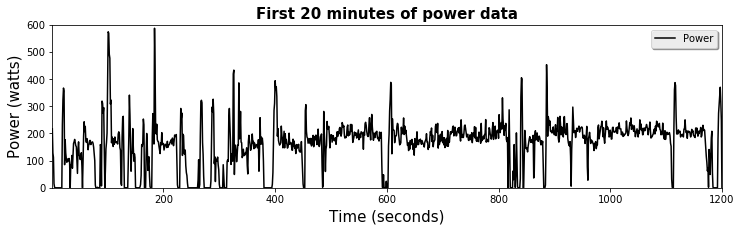

In [26]:
from sklearn.preprocessing import Imputer, StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

# convert all infinite values to nans
xTrain[ np.isinf( xTrain ) ] = np.nan
xTest[ np.isinf( xTest ) ] = np.nan

# construct imputer and scaler
myImputer = Imputer( missing_values='NaN', strategy='median', axis=0 )
myScaler = StandardScaler()

# impute NaNs
xTrain = myImputer.fit_transform( xTrain )
xTest = myImputer.transform( xTest )

# remove mean and divide by standard deviation
xTrain = myScaler.fit_transform( xTrain )
xTest = myScaler.transform( xTest )

# plot the first 20 minutes of power data
# in the training dataset




plt.plot( np.linspace(1,1200,1200), yTest[:1200], color='black', label='Power' )
plt.legend( shadow=True, loc=1 )

ax = plt.gca()
ax.set_xlabel('Time (seconds)', fontsize=15)
ax.set_ylabel('Power (watts)', fontsize=15)
ax.set_title('First 20 minutes of power data', fontsize=15, fontweight='bold' )
ax.set_xlim([1,1200])
ax.set_ylim([0,600])

fig = plt.gcf()
fig.set_size_inches( (12,3) )

plt.show()


## The models

Here we describe the particular algorthims/models we are going to train. For each model a brief description is given of how it works and a few pros and cons.

### Multiple Linear Regression (MLR)
* Assumes that the output variable (power) is a linear function of all the input variables, and that there is zero colinearity between input variables. 
* Assumes that the errors of such a model form a normal distribution. 
* Pros: simple interpretation; computationally inexpensive.
* Cons: we do have colinearity in the input data; it cannot capture nonlinear behaviour in the data (i.e. it will likely underfit); it is sensitive to the scaling of the data.

### K-Nearest Neighbour Regressor (KNNR)
* Simply finds the K data points in the training data which most closely match (based on Euclidean distace) the data point being predicted, and averages the output values for the K data point.
* It assumes that the Euclidean distance between data points is an accurate measure of how 'similar' two data points are.
* Pros: it can capture nonlinear behaviour; is intuitive.
* Cons: can sometimes be computationally expensive to calculate the Euclidean distances; as it is instance based, it doesn't generalise well to new situations.

### Random Forest Regressor (RFR)
* An ensemble method that averages the predctions of many (independent) decisions trees; each tree is built using a random (bootstrapped) selection of the training data. Feature variables are also randomly at each node within the trees. 
* Pros: requires very little hyperparameter tuning; unlikely to overfit; insensitive to input scaling or type.
* Cons: can use a lot of memory to build; need to use a large number of trees; lacks interpretability.

### Multi-Layer Perceptron (MLP)
* A popular form of artifical neural network which contains one or more layers of hidden units. Perceptron models, and the associated back-propagation algorithm, are loosely based on how neurons fire in the brain. 
* Pros: can learn any nonlinear function; has potential to generalise well.
* Cons: bit of a 'black blox'; lots of hyperparameters to tune; can be difficult to train.

## Construct and train models 

We will use Scikit Learn to construct all our models, but if you start doing more computationally intense projects with neural networks, then I recommend using the [Keras](https://keras.io/) API which works on top of [TensorFlow](https://www.tensorflow.org/).

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# model names
modelNames = [ 'Linear Regression', 'K-Nearest', 'Random Forest', 'Neural Network' ]

# construct models
modelList =  [ LinearRegression(),
               KNeighborsRegressor( n_neighbors=75 ),
               RandomForestRegressor( n_estimators=500, n_jobs=3 ),
               MLPRegressor( hidden_layer_sizes=(7,7), learning_rate_init=0.0005, 
                            alpha=0.0, max_iter=1000 )
             ]

# train each model
for model in modelList:
    
    print "\nCurrently training:\n\t", model, "\n"
    model.fit( xTrain, yTrain )
    print "Done!"




Currently training:
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

Done!

Currently training:
	KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=75, p=2,
          weights='uniform') 

Done!

Currently training:
	RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Done!

Currently training:
	MLPRegressor(activation='relu', alpha=0.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 7), learning_rate='constant',
       learning_rate_init=0.0005, max_iter=1000, momentum=0.9,
       nes

### Model Evaluation

We want to see how well our models fit the training data and then generalised to previously unseen test data. We'll use the R<sup>2</sup> coefficient of determination - this gives the models performance relative to using the expected value, i.e. a perfect model would give R<sup>2</sup>=1, simply using the average power would give R<sup>2</sup>=0, and a really bad model produces R<sup>2</sup> of less than zero.

In [28]:
# loop through each model and calculate the score
for i, model in enumerate( modelList ) :
    
    print modelNames[i], ":", np.round( model.score( xTest, yTest ), 4 )
    

Linear Regression : 0.0614
K-Nearest : 0.0929
Random Forest : 0.0913
Neural Network : 0.0945


As we can see, all the models do slightly better than simply predicting the average power, but not by much. This shows how difficult this problem is, even when you apply fancy machine learning methods at it. The neural network came out on top, but the real surprise is how well the K-Nearest Neighbour algorithm (the underdog of the group) performed. The K-Nearest model performed better than random forest and wasn't far off the neural network. The poor performance by the linear regression shows that there are complex nonlinear interactions in the data which are important.

Let's now plot so of these predictions to get a feel of their performance. We'll take the final 20 minutes of riding in the test data and will plot each models prediction.

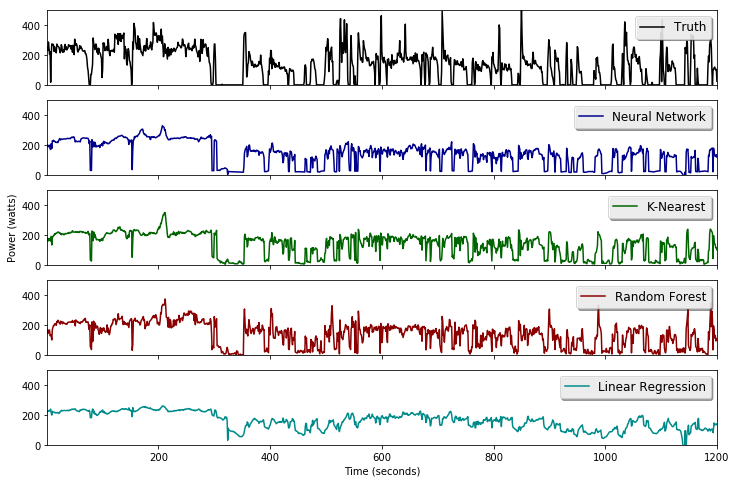

In [29]:
# construct figure
fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1,sharex=True)
fig.set_size_inches( (12,8) )

time = np.linspace(1,1200,1200)

# plot the true values, and then the model predictions
ax0.plot( time, yTest[-1200:], color='black', label='Truth' )
ax1.plot( time, modelList[3].predict( xTest[-1200:] ), label=modelNames[3], color='darkblue' )
ax2.plot( time, modelList[1].predict( xTest[-1200:] ), label=modelNames[1], color='darkgreen' )
ax3.plot( time, modelList[2].predict( xTest[-1200:] ), label=modelNames[2], color='darkred' )
ax4.plot( time, modelList[0].predict( xTest[-1200:] ), label=modelNames[0], color='darkcyan' )

ax0.set_xlim( (1,1200) )
ax1.set_xlim( (1,1200) )
ax2.set_xlim( (1,1200) )
ax3.set_xlim( (1,1200) )
ax4.set_xlim( (1,1200) )

ax0.set_ylim( (0,500) )
ax1.set_ylim( (0,500) )
ax2.set_ylim( (0,500) )
ax3.set_ylim( (0,500) )
ax4.set_ylim( (0,500) )

ax0.legend( shadow=True, loc=1, fontsize=12 )
ax1.legend( shadow=True, loc=1, fontsize=12 )
ax2.legend( shadow=True, loc=1, fontsize=12 )
ax3.legend( shadow=True, loc=1, fontsize=12 )
ax4.legend( shadow=True, loc=1, fontsize=12 )

ax4.set_xlabel('Time (seconds)')
ax2.set_ylabel('Power (watts)')

plt.show()

One important test of these models is that they go to zero when the power goes to zero.  The neural network, K-nearest, and random forest models manage to do this fairly well whereas the linear regression model hangs around 100 watts (check out the extended period of zero power at roughly 350 seconds). The linear regression model is also too smooth; it doesn't capture the short time-scale fluctuations that we see in the top panel showing the true data. 

All models (except linear regression) do generally track the true changes in power - this is especially clear in the final 2000 seconds. They just can't quite get the magnitude of the spikes in power. This is likely due to the fact that when a cyclist goes above anaerobic threshold, power output decouples from heartrate and becomes harder to predict. 

We can now ask the question: do all the input features contribute to these predictions? Or is it only one or two features that produce the majority of the predictive skill? To answer this question, we can use the 'feature importances' generated by the random forest model. These feature importances tell us the relative importance of each variables (for more information on how they're calculated, see [this](http://freakonometrics.hypotheses.org/19835)).

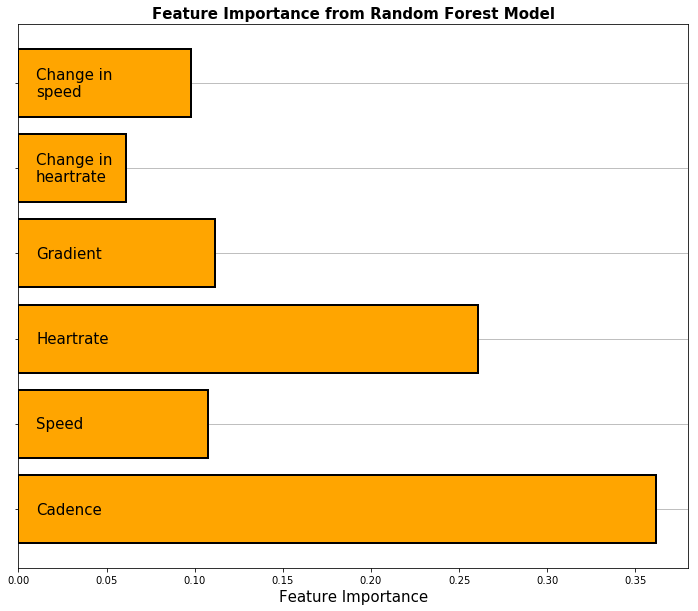

In [30]:
# extract feature importances from random forest model
featImpo = modelList[2].feature_importances_

# make list of feature names
features = [ 'Cadence', 'Speed', 'Heartrate', 
            'Gradient', 'Change in \nheartrate', 'Change in \nspeed' ]

# plot a bar chart
plt.barh( [1,2,3,4,5,6], featImpo, color='orange', edgecolor='black', linewidth=2 )

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches( (12,10) )
ax.set_xlabel( 'Feature Importance', fontsize=15 )
ax.yaxis.grid(True)
ax.yaxis.set_ticklabels([])
ax.set_axisbelow(True)
ax.set_title('Feature Importance from Random Forest Model', fontsize=15, fontweight='bold' )

# annotate
for i in range(6) :
    plt.text( 0.01, i+1, features[i], fontsize=15, va='center' )
    
plt.show()


It's clear that heartrate and cadence are the best predictors and this makes intuitive sense. I wonder if the accuracy would imporve if PowerTap included cadence data into their PowerCal algorithm. I thought that the change in heartrate feature would have been more useful than it is - maybe the lack of predictability of this feature is due to the time delay between changes in power output and change in heartrate. 

In the future it would be interesting to compare these purely statistical models with a physical model that makes simple assumptions about rolling resistance and wind drag. In the meantime however, even though the statistical models did a fairly good job, I won't be selling my powermeter anytime soon.

(The python scripts, notebook, and data can be found [here on GitHub](https://github.com/TomBolton/powerPredictions))